In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pypsa

In [2]:
def get_time_index(year):
    t = pd.date_range('%d-01-01 00:00'%year, '%d-12-31 23:00'%year, freq = 'H')
    if (year%100 != 0 and year%4 == 0) or year%400 == 0: # leap year
        t = t[:1416].union(t[1440:]) # drop 2/29 due to lack of data
    return t

# weather data from refinement
def get_capacity_factor(t,lat_lon):
    cf = pd.DataFrame(index = t, columns = ['Wind','PV'])
    cf.Wind = pd.read_csv('data/cf/wind_%s.csv'%lat_lon, index_col = 0).to_numpy()
    cf.PV = pd.read_csv('data/cf/pv_%s.csv'%lat_lon, index_col = 0).to_numpy()
    return cf

def fast_fourier_transform(cf,fs): # pandas series of capacity factor, sampling rate
    y = cf.values # array
    N = y.size # sampling points amount
    dt = 1/fs # sampling period
    xf = np.fft.rfftfreq(N, dt) # frequency
    yf = np.fft.rfft(y) # intensity
    ym = 2/N*abs(yf) # amplitude normalization
    ym[0] = ym[0]/2 # amplitude normalization
    return xf, yf, ym

In [3]:
t = get_time_index(2030)
cf = get_capacity_factor(t,'56.4000_6.8000')
xwind, temp, ywind = fast_fourier_transform(cf['Wind'],1/3600)
xpv, temp, ypv = fast_fourier_transform(cf['PV'],1/3600)

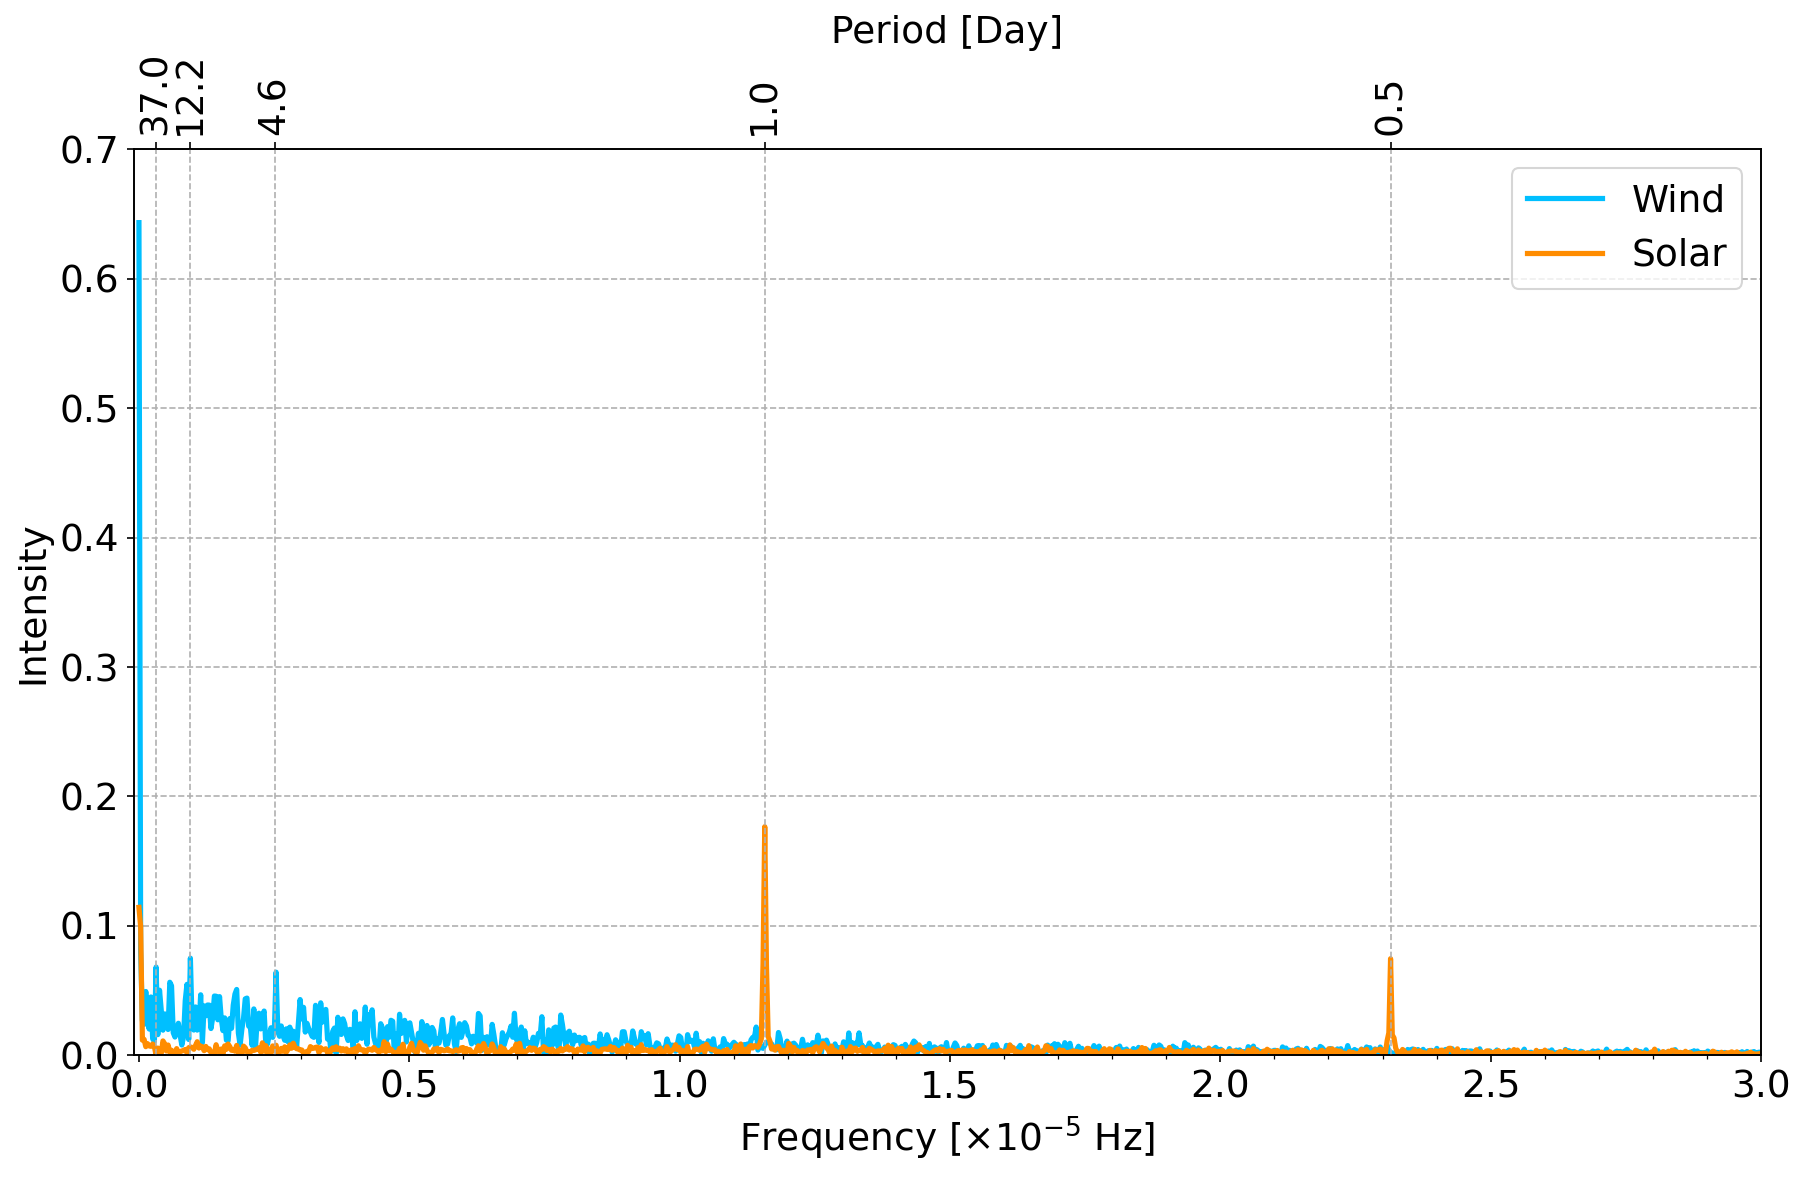

In [64]:
plt.rcParams.update({'font.size': 18})

fig, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = (14,8), dpi = 150)
ax1.plot(xwind, ywind, linewidth = 2.5, c = 'deepskyblue', label = 'Wind')
ax1.plot(xpv, ypv, linewidth = 2.5, c = 'darkorange', label = 'Solar')
ax1.set_xlim(-1e-7,3e-5)
ax1.set_ylim(0,0.7)
ax1.set_xticks(np.arange(0,3e-5,1e-6), minor = True)
ax1.grid(axis = 'y', linestyle = '--')
ax1.set_xlabel(r'Frequency [$\times$10$^{%i}$ Hz]'%int(np.floor(np.log10(max(ax1.get_xticks())))))
ax1.set_ylabel('Intensity')
ax1.legend(loc = 'upper right')

ax2 = ax1.twiny()
days = np.array([37,12.2,4.6,1,0.5])
ax2.set_xlim(-1e-7,3e-5)
ax2.set_xticks(1/(days*86400))
ax2.set_xticklabels(days, rotation = 90)
ax2.grid(axis = 'x', linestyle = '--')
ax2.set_xlabel('Period [Day]')

ax1.get_xaxis().get_offset_text().set_visible(False)
plt.show()

In [5]:
country = ['DK','DE','NO','NL','GB']
binary_list = []
for i in range(2**len(country)):
    binary_list.append(f'{{:0{len(country)}b}}'.format(i))

locvar = locals()
for year in [2030,2040,2050]:
    for fuel in ['H2','NH3']:
        for binary in binary_list:
            locvar['network_%d_%s_%s'%(year,fuel,binary)] = pypsa.Network('results/%d_%s_%s.nc'%(year,fuel,binary))

INFO:pypsa.io:Imported network 2030_H2_00000.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2030_H2_00001.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2030_H2_00010.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2030_H2_00011.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2030_H2_00100.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2030_H2_00101.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2030_H2_00110.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2030_H2_00111.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2030_H2_01000.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2030_H2_01001.nc has buses, generators, links, loads, storage_units
INFO:pypsa

INFO:pypsa.io:Imported network 2040_H2_10011.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2040_H2_10100.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2040_H2_10101.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2040_H2_10110.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2040_H2_10111.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2040_H2_11000.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2040_H2_11001.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2040_H2_11010.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2040_H2_11011.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2040_H2_11100.nc has buses, generators, links, loads, storage_units
INFO:pypsa

INFO:pypsa.io:Imported network 2050_NH3_00110.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2050_NH3_00111.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2050_NH3_01000.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2050_NH3_01001.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2050_NH3_01010.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2050_NH3_01011.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2050_NH3_01100.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2050_NH3_01101.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2050_NH3_01110.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2050_NH3_01111.nc has buses, generators, links, loads, storage_units


In [39]:
lfc = []
for year in [2030,2040,2050]:
    for fuel in ['H2','NH3']:
        for binary in binary_list:
            lfc.append(locvar['network_%d_%s_%s'%(year,fuel,binary)].buses_t.marginal_price[fuel].mean())

In [366]:
barcolors = ['black']
combination = ['Isolated']
for binary in binary_list:
    if binary == '00000':
        continue
    for i,j in zip(binary,country):
        if int(i):
            try:
                combination[binary_list.index(binary)] += '+'+j
            except IndexError:
                combination.append(j)
    if len(combination[-1]) == 2:
        barcolors.append('red')
    elif len(combination[-1]) == 5:
        barcolors.append('gold')
    elif len(combination[-1]) == 8:
        barcolors.append('limegreen')
    elif len(combination[-1]) == 11:
        barcolors.append('dodgerblue')
    elif len(combination[-1]) == 14:
        barcolors.append('darkviolet')

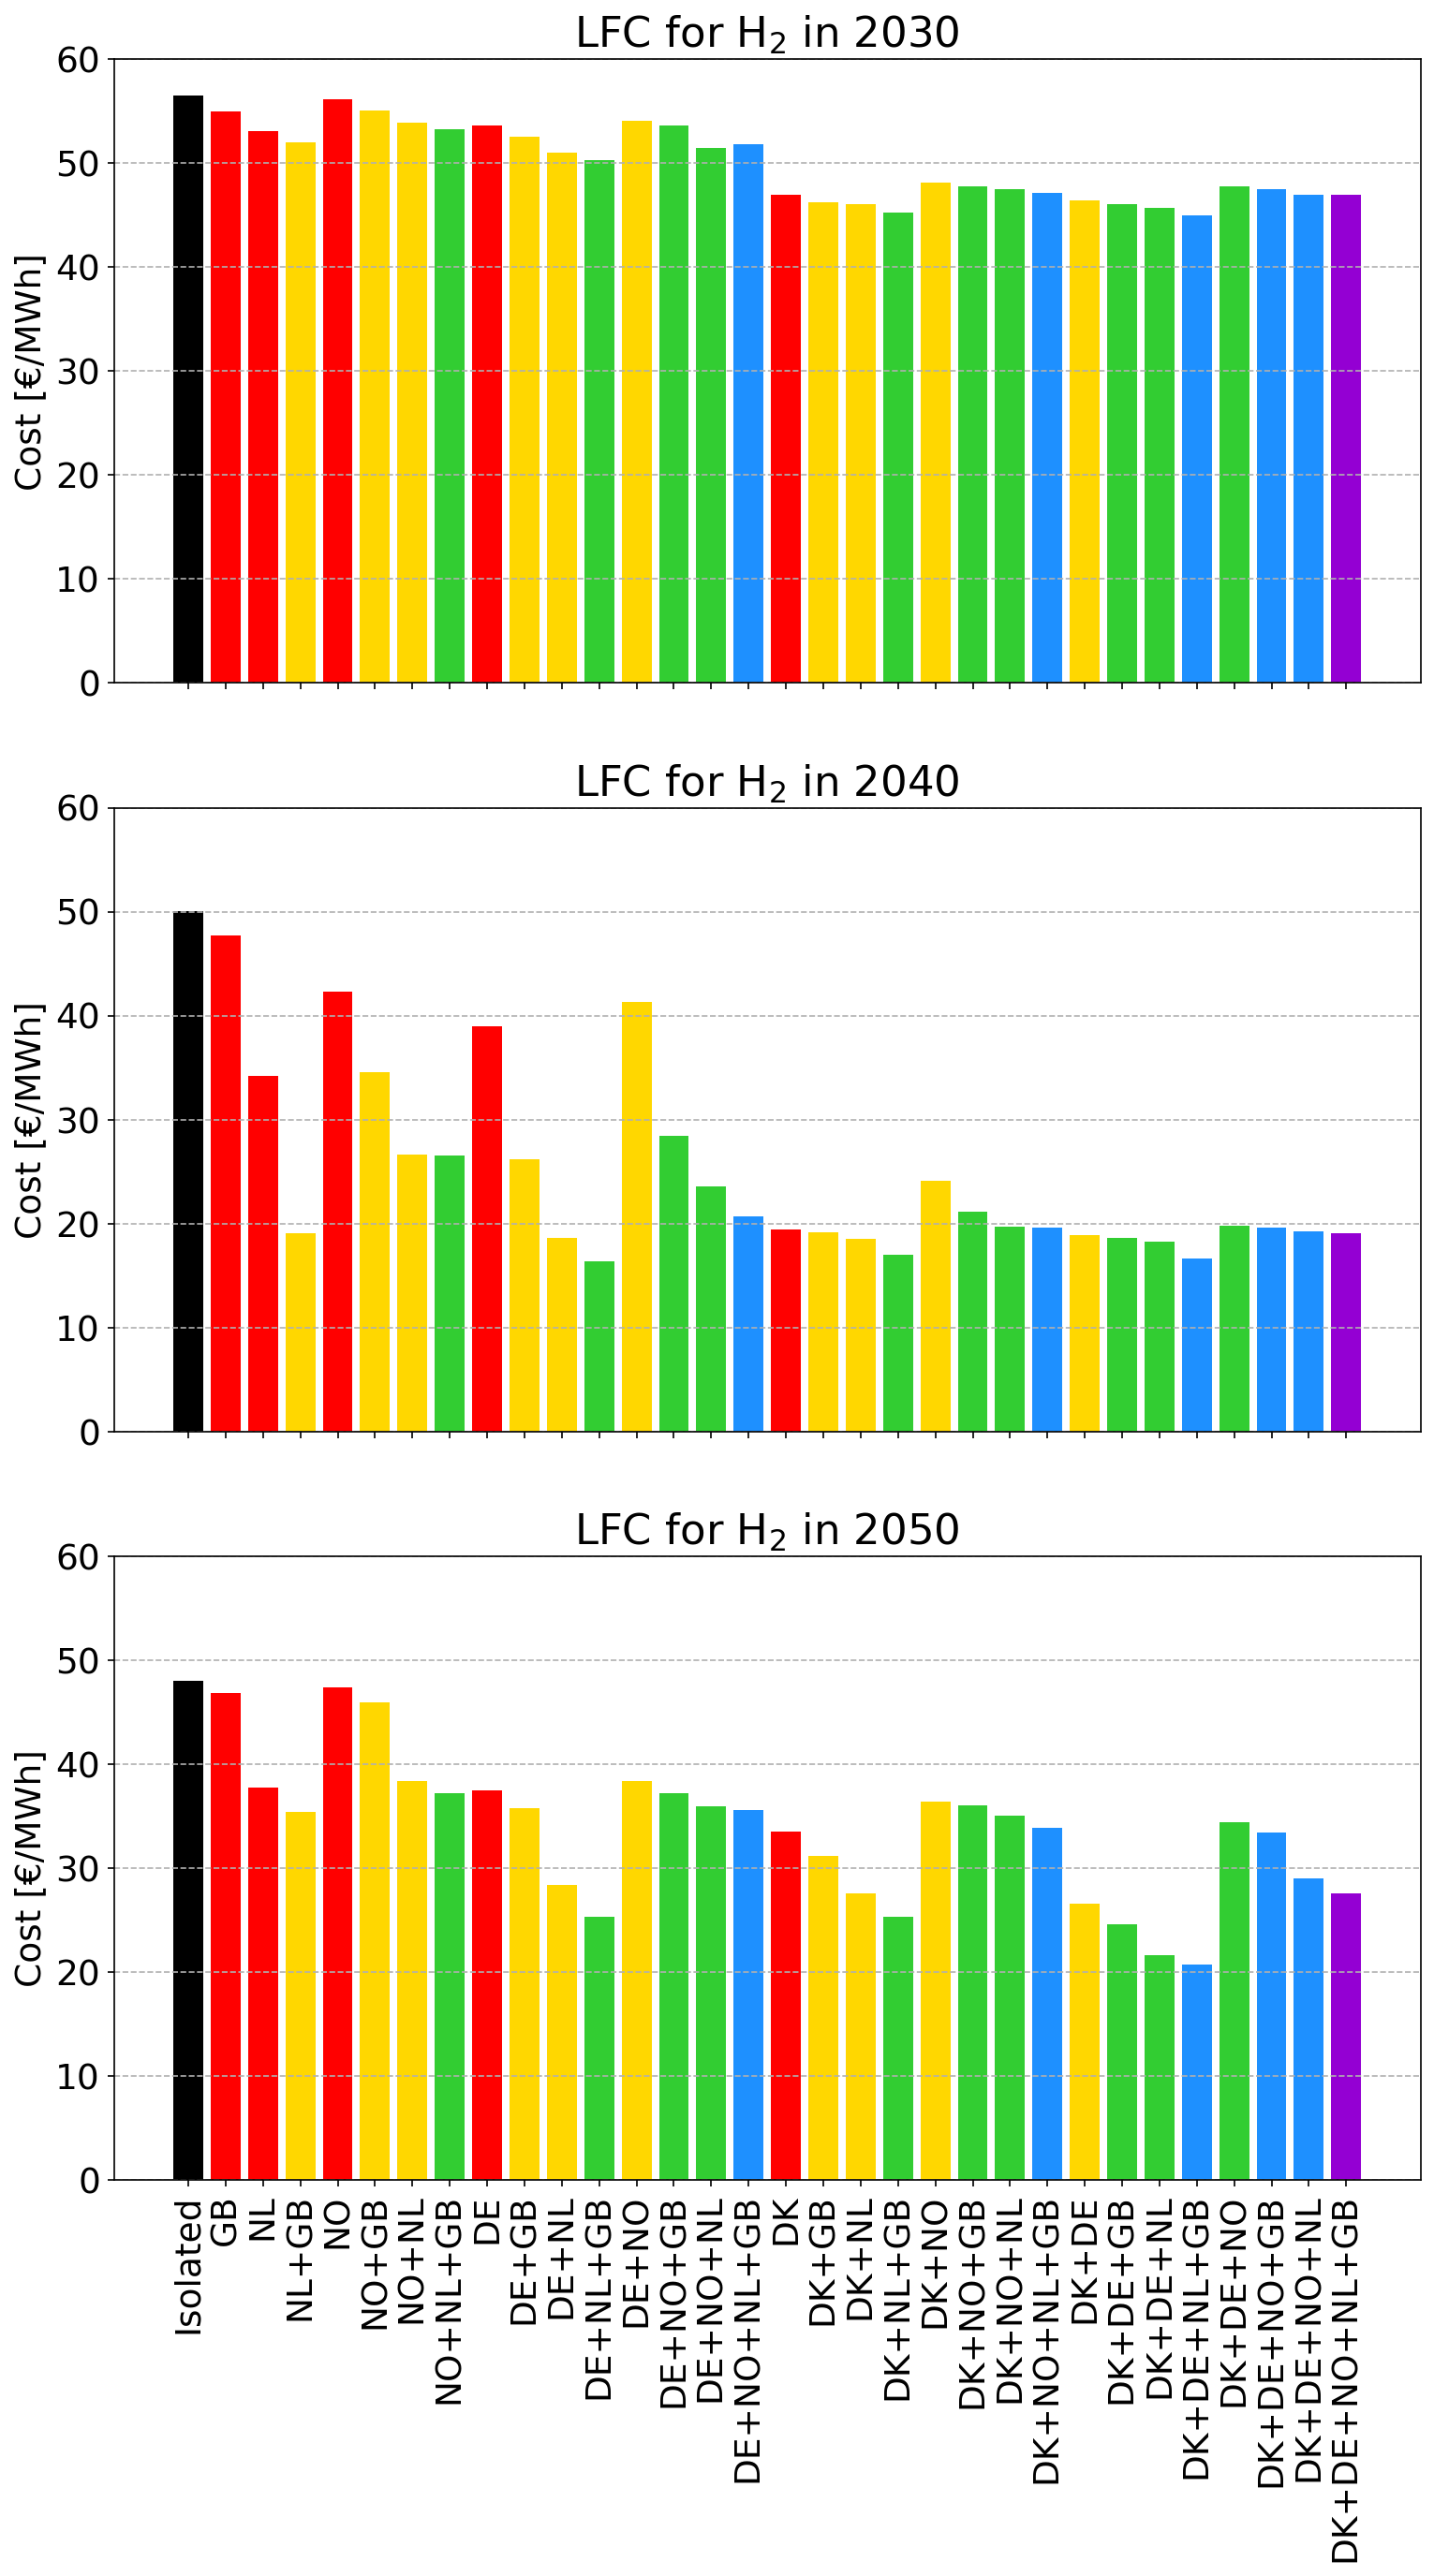

In [367]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, sharex = True, figsize = (12,20), dpi = 150)
ax1.bar(combination, lfc[0:32], color = barcolors)
ax1.set_ylim(0,60)
ax1.set_yticks(np.arange(0,61,10))
ax1.grid(axis = 'y', linestyle = '--')
ax1.set_title(r'LFC for H$_2$ in 2030')
ax1.set_ylabel('Cost [€/MWh]')

ax2.bar(combination, lfc[64:96], color = barcolors)
ax2.set_ylim(0,60)
ax2.set_yticks(np.arange(0,61,10))
ax2.grid(axis = 'y', linestyle = '--')
ax2.set_title(r'LFC for H$_2$ in 2040')
ax2.set_ylabel('Cost [€/MWh]')

ax3.bar(combination, lfc[128:160], color = barcolors)
ax3.set_ylim(0,60)
ax2.set_yticks(np.arange(0,61,10))
ax3.grid(axis = 'y', linestyle = '--')
ax3.set_title(r'LFC for H$_2$ in 2050')
ax3.set_ylabel('Cost [€/MWh]')
ax3.tick_params(axis = 'x', rotation = 90)
plt.show()

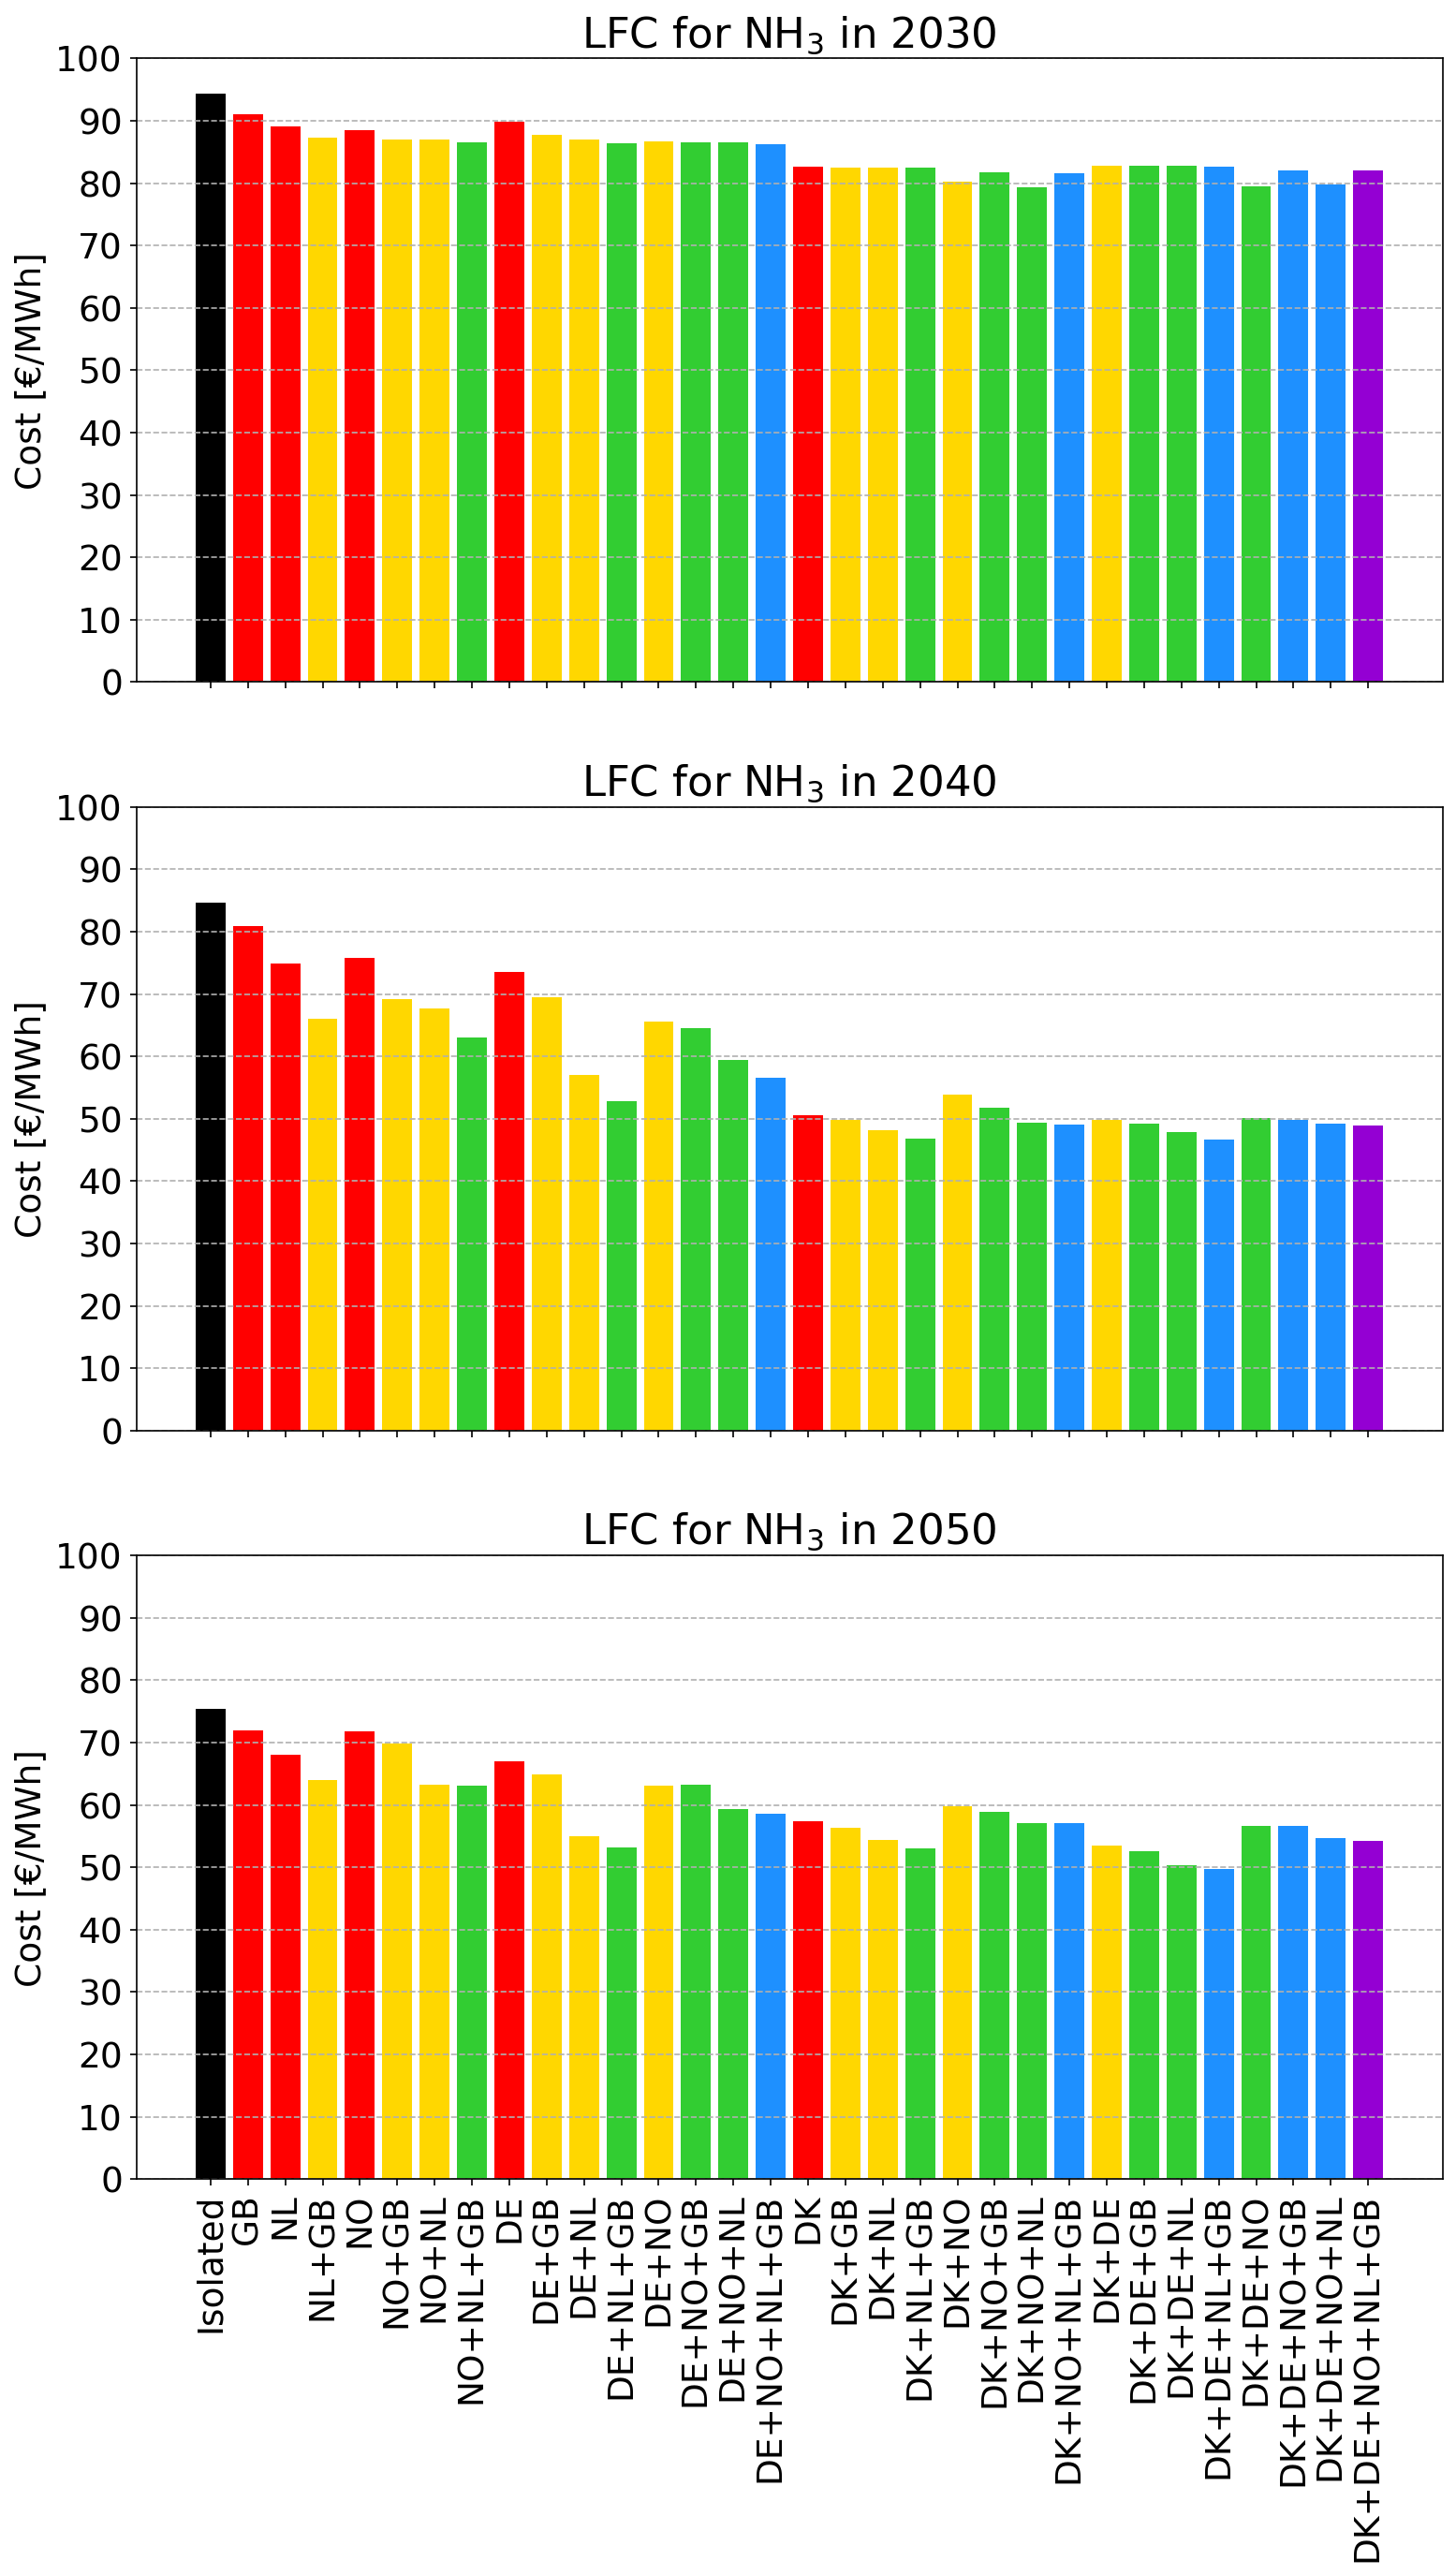

In [368]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, sharex = True, figsize = (12,20), dpi = 150)
ax1.bar(combination, lfc[32:64], color = barcolors)
ax1.set_ylim(0,100)
ax1.set_yticks(np.arange(0,101,10))
ax1.grid(axis = 'y', linestyle = '--')
ax1.set_title(r'LFC for NH$_3$ in 2030')
ax1.set_ylabel('Cost [€/MWh]')

ax2.bar(combination, lfc[96:128], color = barcolors)
ax2.set_ylim(0,100)
ax2.set_yticks(np.arange(0,101,10))
ax2.grid(axis = 'y', linestyle = '--')
ax2.set_title(r'LFC for NH$_3$ in 2040')
ax2.set_ylabel('Cost [€/MWh]')

ax3.bar(combination, lfc[160:192], color = barcolors)
ax3.set_ylim(0,100)
ax3.set_yticks(np.arange(0,101,10))
ax3.grid(axis = 'y', linestyle = '--')
ax3.set_title(r'LFC for NH$_3$ in 2050')
ax3.set_ylabel('Cost [€/MWh]')
ax3.tick_params(axis = 'x', rotation = 90)
plt.show()

In [369]:
def get_bar_capacities(binary):
    index = ['Offshore Wind','Battery','Fuel Plant']
    for i,j in zip(binary,country):
        if int(i): index.append(j+' Link')
    capacities = pd.DataFrame(
        columns = [f'{year}_{fuel}' for year in [2030,2040,2050] for fuel in ['H2','NH3']], index = index
    )
    for year in [2030,2040,2050]:
        for fuel in ['H2','NH3']:
            capacities.loc[:,f'{year}_{fuel}'] = np.concatenate(
                (locvar['network_%d_%s_%s'%(year,fuel,binary)].generators.p_nom_opt.filter(regex = r'Wind|Solar'),
                 locvar['network_%d_%s_%s'%(year,fuel,binary)].storage_units.p_nom_opt.filter(regex = r'Battery'),
                 locvar['network_%d_%s_%s'%(year,fuel,binary)].links.p_nom_opt.filter(regex = r'Plant| and '))
            )
    return capacities

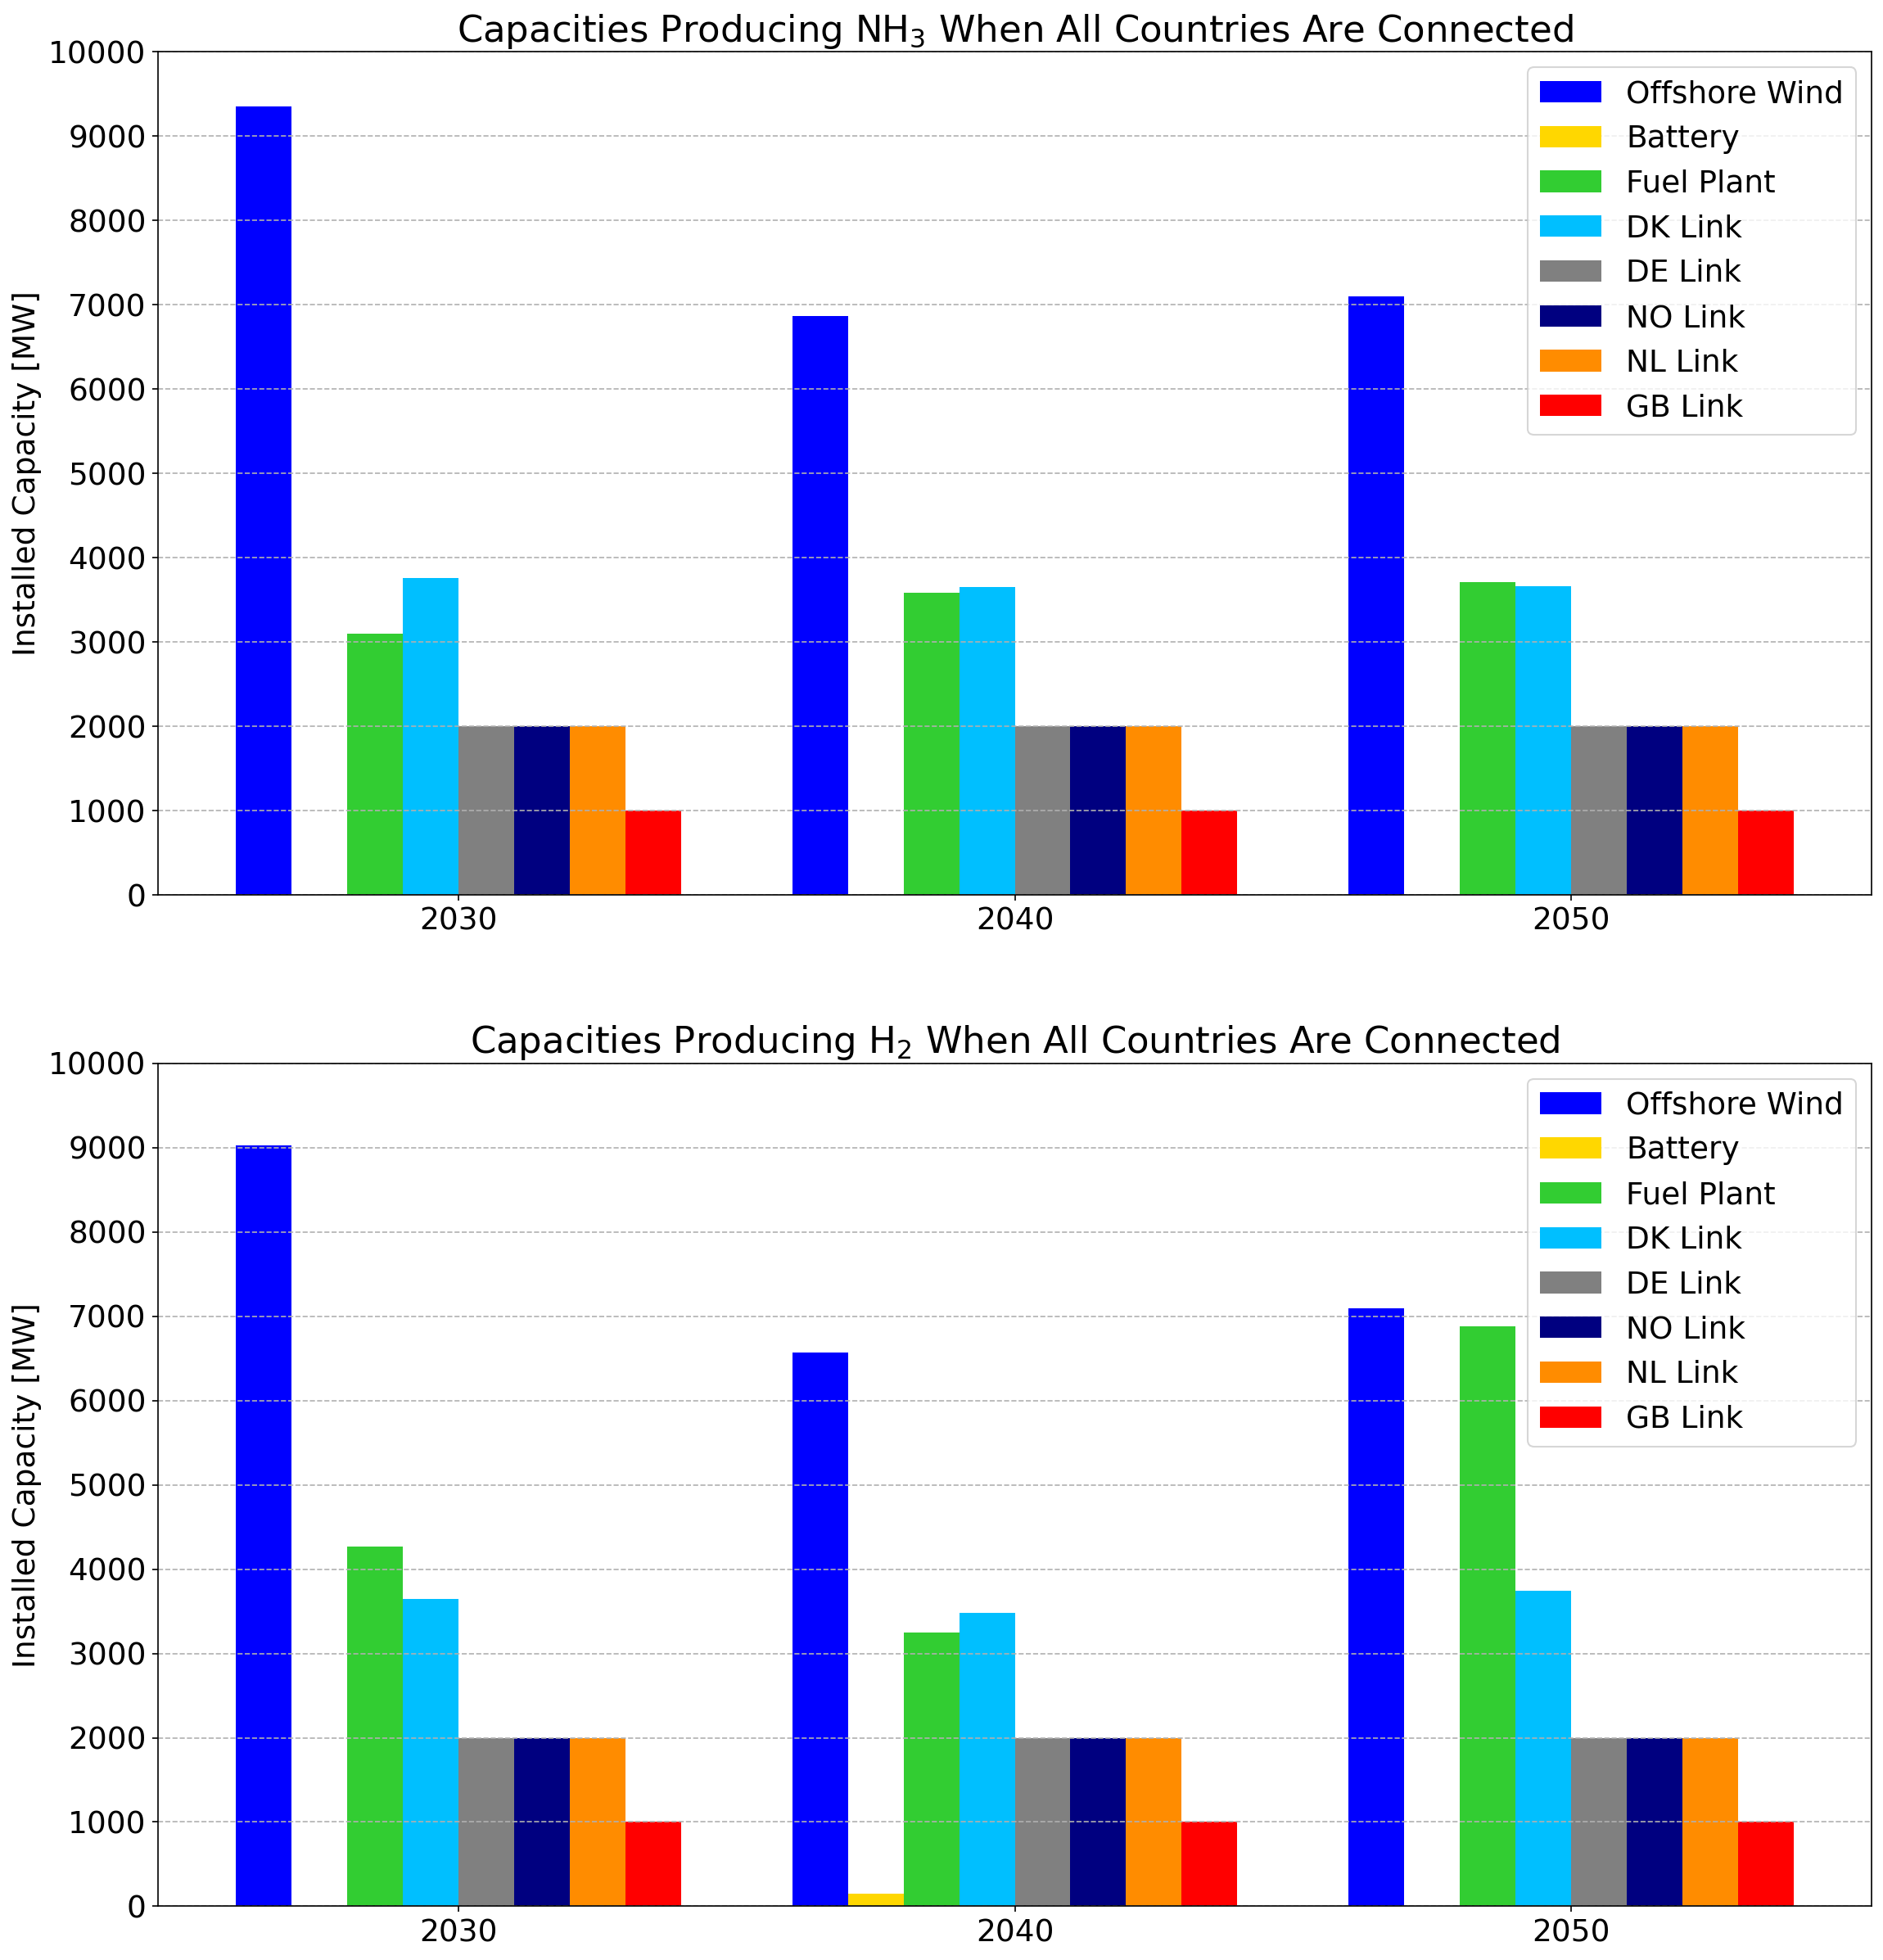

In [370]:
capacities = get_bar_capacities('11111')
colors = ['blue','gold','limegreen','deepskyblue','grey','navy','darkorange','red']

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (18,20), dpi = 150)
x = np.arange(3)
width = 0.1
for i,j in zip(np.arange(len(capacities.index)),capacities.index):
    ax1.bar(x+width*i, capacities.loc[j].filter(regex = r'NH3'), width, color = colors[i], label = j)
    ax2.bar(x+width*i, capacities.loc[j].filter(regex = r'H2'), width, color = colors[i], label = j)
ax1.set_ylim(0,10000)
ax2.set_ylim(0,10000)
ax1.grid(axis = 'y', linestyle = '--')
ax2.grid(axis = 'y', linestyle = '--')
ax1.set_title(r'Capacities Producing NH$_3$ When All Countries Are Connected')
ax2.set_title(r'Capacities Producing H$_2$ When All Countries Are Connected')
ax1.set_ylabel('Installed Capacity [MW]')
ax2.set_ylabel('Installed Capacity [MW]')
ax1.set_xticks(x+width*3.5)
ax2.set_xticks(x+width*3.5)
ax1.set_xticklabels([2030,2040,2050])
ax2.set_xticklabels([2030,2040,2050])
ax1.set_yticks(np.arange(0,10001,1000))
ax2.set_yticks(np.arange(0,10001,1000))
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
plt.show()

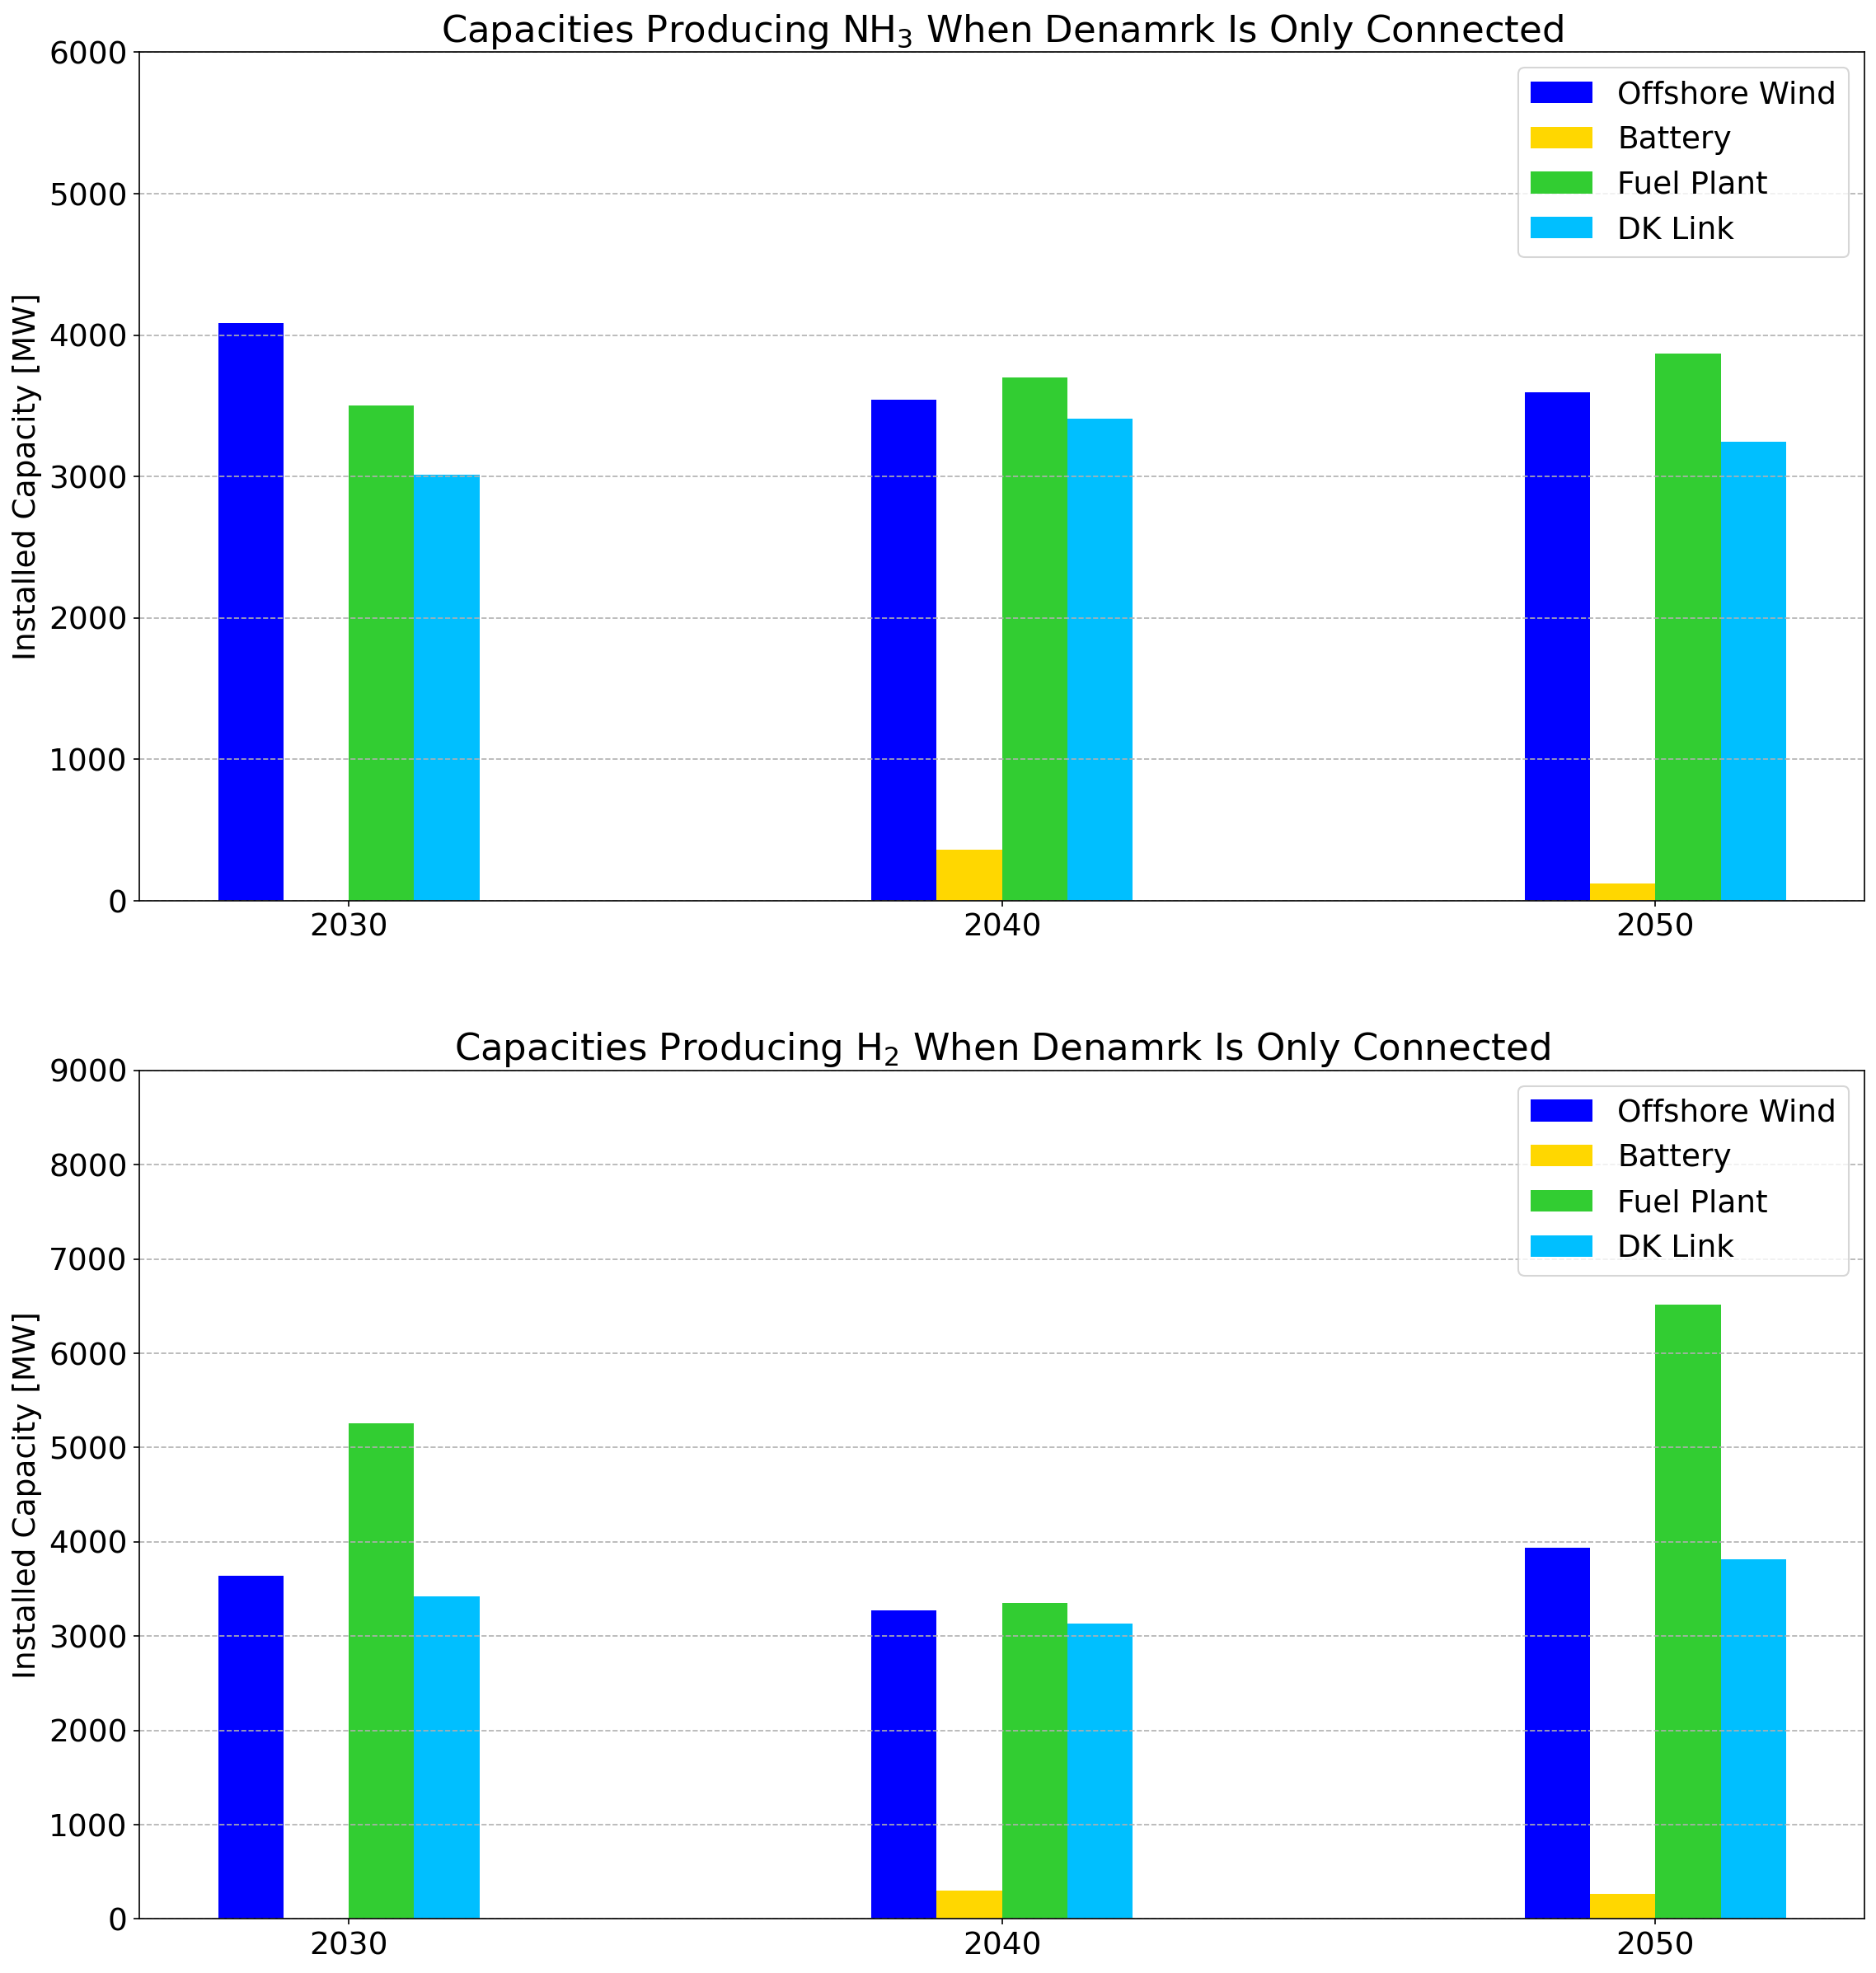

In [371]:
capacities = get_bar_capacities('10000')
colors = ['blue','gold','limegreen','deepskyblue']

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (18,20), dpi = 150)
x = np.arange(3)
width = 0.1
for i,j in zip(np.arange(len(capacities.index)),capacities.index):
    ax1.bar(x+width*i, capacities.loc[j].filter(regex = r'NH3'), width, color = colors[i], label = j)
    ax2.bar(x+width*i, capacities.loc[j].filter(regex = r'H2'), width, color = colors[i], label = j)
ax1.set_ylim(0,6000)
ax2.set_ylim(0,9000)
ax1.grid(axis = 'y', linestyle = '--')
ax2.grid(axis = 'y', linestyle = '--')
ax1.set_title(r'Capacities Producing NH$_3$ When Denamrk Is Only Connected')
ax2.set_title(r'Capacities Producing H$_2$ When Denamrk Is Only Connected')
ax1.set_ylabel('Installed Capacity [MW]')
ax2.set_ylabel('Installed Capacity [MW]')
ax1.set_xticks(x+width*1.5)
ax2.set_xticks(x+width*1.5)
ax1.set_xticklabels([2030,2040,2050])
ax2.set_xticklabels([2030,2040,2050])
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
plt.show()